In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.python import keras

In [0]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = './dataset'
width=224
height=224
depth=3

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#4/EAHvxOwTUUc5P4f054p_XPb6LUtIp67TjDF6lZaN8qOKZAuMbtL9Fow

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/MP - Benette"

alexnet64.h5  dataset.zip  models  nchecknet80.h5  notebook


In [0]:
!ls 

dataset  drive	sample_data


In [0]:
!unzip "/content/drive/My Drive/MP - Benette/dataset.zip"

  inflating: dataset/Grape/Grape___healthy/b25497ff-4272-43e3-8ead-71b57c676529___Mt.N.V_HL 9087.JPG  
  inflating: dataset/Grape/Grape___healthy/b297f494-eb0a-407f-8edf-25ecdbf278bf___Mt.N.V_HL 9022.JPG  
  inflating: dataset/Grape/Grape___healthy/b2de09b2-4c5d-4be5-a06f-27419db0f696___Mt.N.V_HL 6097.JPG  
  inflating: dataset/Grape/Grape___healthy/b2e93b6f-8a63-43f7-9305-dbad31dceda6___Mt.N.V_HL 9064.JPG  
  inflating: dataset/Grape/Grape___healthy/b3a5441e-385d-444e-bf4b-3c7d3cdf36e6___Mt.N.V_HL 9101.JPG  
  inflating: dataset/Grape/Grape___healthy/b4cbb49f-8418-4631-a151-e69fe1f35cea___Mt.N.V_HL 9074.JPG  
  inflating: dataset/Grape/Grape___healthy/b53106de-9795-4c49-ab42-6aac4ff9c886___Mt.N.V_HL 6157.JPG  
  inflating: dataset/Grape/Grape___healthy/b556f11d-115a-4bac-8120-05195ac42e1d___Mt.N.V_HL 9123.JPG  
  inflating: dataset/Grape/Grape___healthy/b57b3a18-da12-4b34-b0a7-6b2dfe58871f___Mt.N.V_HL 6065.JPG  
  inflating: dataset/Grape/Grape___healthy/b67328d6-9735-4220-83a6-3b3568

In [0]:


def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None



In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
# pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 2) 

[INFO] Spliting data to train, test


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
#My Net


model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
    
    
model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))


model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))


model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))


model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(515))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:


opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")



[INFO] training network...


In [0]:


history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )



Epoch 1/25
20/20 [==============================] - 104s 5s/step - loss: 0.3980 - acc: 0.8602 - val_loss: 1.5436 - val_acc: 0.6406
Epoch 2/25
20/20 [==============================] - 101s 5s/step - loss: 0.2408 - acc: 0.9082 - val_loss: 2.7128 - val_acc: 0.6406
Epoch 3/25
20/20 [==============================] - 101s 5s/step - loss: 0.1913 - acc: 0.9180 - val_loss: 4.4732 - val_acc: 0.6406
Epoch 4/25
20/20 [==============================] - 100s 5s/step - loss: 0.1725 - acc: 0.9355 - val_loss: 4.7522 - val_acc: 0.6406
Epoch 5/25
20/20 [==============================] - 101s 5s/step - loss: 0.1617 - acc: 0.9414 - val_loss: 3.5470 - val_acc: 0.6406
Epoch 6/25
20/20 [==============================] - 101s 5s/step - loss: 0.1266 - acc: 0.9484 - val_loss: 4.8787 - val_acc: 0.6406
Epoch 7/25
20/20 [==============================] - 101s 5s/step - loss: 0.1486 - acc: 0.9406 - val_loss: 5.6112 - val_acc: 0.6406
Epoch 8/25
20/20 [==============================] - 102s 5s/step - loss: 0.1260 - a

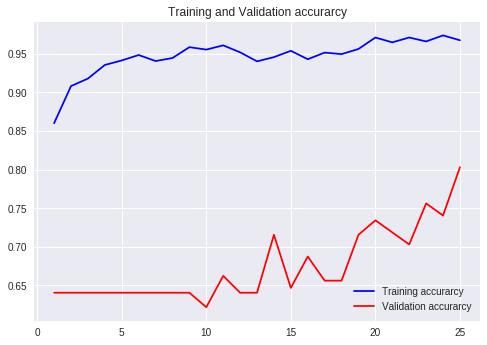

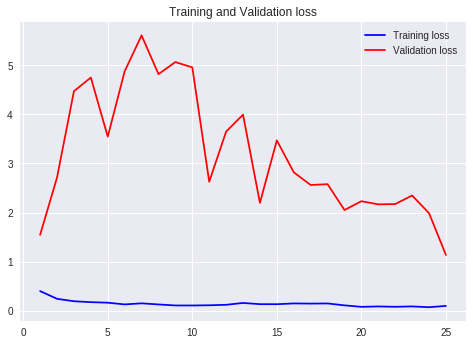

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [0]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
160/160 [==============================] - 4s 28ms/sample - loss: 1.1352 - acc: 0.8031
Test Accuracy: 80.31250238418579


In [0]:
!pip install h5py pyyaml 

In [0]:
model.save('nchecknet80.h5')

In [0]:
#Trials


!mv 'nchecknet80.h5' '/content/drive/My Drive/MP - Benette'
